# Group-based Regression Models

### Importing libraries and define functions

In [1]:
import pandas as pd
import numpy as np
import scipy
import math
import os
import sys

In [2]:
# Managing Warnings 
import warnings
warnings.filterwarnings('ignore')

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses

In [3]:
import sklearn
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.impute import SimpleImputer

In [4]:
from pycaret.regression import *

In [5]:
import functions as f

# Nanotubes regression model

In [6]:
model_name = "nanotube"
group_name = "nanotubes"
seed = 123

### Load the data and filter instances

In [7]:
data_train_df = pd.read_csv("output/datasets/universal/data_regression_train_df.csv", encoding="utf-8")
data_test_df = pd.read_csv("output/datasets/universal/data_regression_test_df.csv", encoding="utf-8")
data_df = pd.concat([data_train_df,data_test_df])

del data_train_df
del data_test_df

In [8]:
data_df.shape

(11315, 20)

In [9]:
data_group_df = data_df[data_df['nanomaterial_group'] == group_name]

In [10]:
data_group_df.shape

(675, 20)

In [11]:
data_group_df.head()

,NP_type,Coating,core_size_nm,hydro_size_nm,Surf_charge_mV,Surface_area_m2_g,shape,Dose_microg_mL,Duration_h,Cell_name,Cell_species,cell_Organ,Cell_morphology,Cell_age,cell_type,sex,Assay,Test_indicator,nanomaterial_group,Viability
22,Nanotubes,None,1.0,NaN,NaN,NaN,NaN,281.9,24.0,A549,Human,Lung,Epithelial,Adult,cancer,male,Alamar_Blue,AlamarBlue,nanotubes,81.83
54,MWCNT,PEG_based,27.3,NaN,-35.6,NaN,Needle,5.0,24.0,RAW 264.7,Mouse,Blood,Macrophage,Adult,cancer,male,WST-1,TetrazoliumSalt,nanotubes,98.65
134,SWCNT,None,601.7,NaN,-13.0,NaN,Needle,12.5,4.0,NR8383,Rat,Lung,Macrophage,Adult,Normal,male,Alamar_Blue,AlamarBlue,nanotubes,85.76
144,MWCNT,None,NaN,NaN,-13.0,NaN,Needle,6.0,4.0,NR8383,Rat,Lung,Macrophage,Adult,Normal,male,Alamar_Blue,AlamarBlue,nanotubes,70.01
151,Nanotubes,None,68.0,NaN,NaN,NaN,NaN,0.0,96.0,HMM,Human,Blood,Monocyte/Macrophage,Adult,Normal,NaN,MTT,TetrazoliumSalt,nanotubes,94.74


### Create training set and test set

In [12]:
data_group_df = f.quantile_discretize(data_group_df, 'Viability')

In [13]:
splitter = setup(data = data_group_df, target = 'Viability_discrete',
                 preprocess = False,
                 train_size=0.8,
                 data_split_stratify=True,
                 # don't change the following
                 session_id = seed,
                 use_gpu=False,
                 log_experiment = False,
                 silent=True,
                 experiment_name = 'splitter')

,Description,Value
0,session_id,123
1,Target,Viability_discrete
2,Original Data,"(675, 21)"
3,Missing Values,True
4,Numeric Features,7
5,Categorical Features,13
6,Transformed Train Set,"(540, 20)"
7,Transformed Test Set,"(135, 20)"
8,Shuffle Train-Test,True
9,Stratify Train-Test,True


In [14]:
data_group_train_df = get_config(variable="X_train").copy()
#data_group_train_df['Viability'] = get_config(variable="y_train").copy()

data_group_test_df = get_config(variable="X_test").copy()
#data_group_test_df['Viability'] = get_config(variable="y_test").copy()

In [15]:
print(data_group_train_df.shape)
print(data_group_test_df.shape)

(540, 20)
(135, 20)


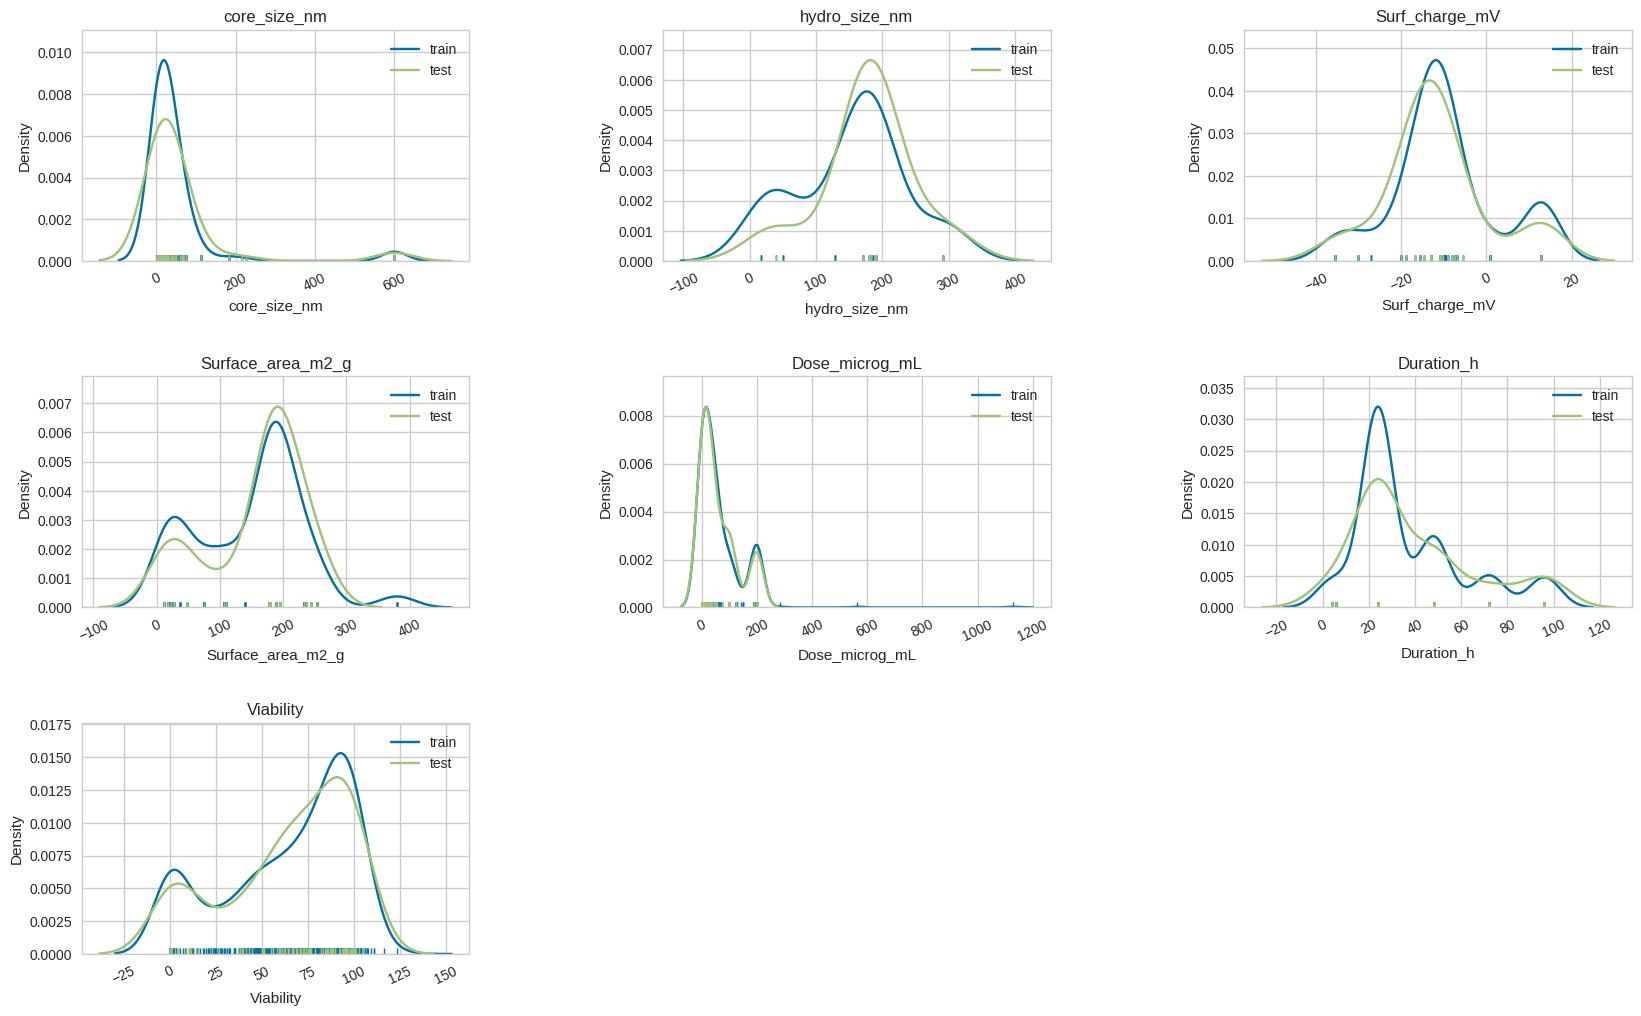

In [16]:
f.plot_distribution_train_test(data_group_train_df, data_group_test_df)

### Save cleaned datasets

In [21]:
data_group_train_df.to_csv('output/datasets/'+model_name+'/data_regression_'+model_name+'_train_df.csv', encoding='utf-8', index=False)

In [22]:
data_group_test_df.to_csv('output/datasets/'+model_name+'/data_regression_'+model_name+'_test_df.csv', encoding='utf-8', index=False)

### Use the best scenario identified in step 01

In [25]:
sc_ignore_features = ['nanomaterial_group', 'Coating', 'Cell_name']
sc_bin_numeric_features = None
sc_high_cardinality_features = None

sc_imputation_type = 'iterative'
sc_numeric_imputation = 'mean'

sc_normalize = True
sc_remove_outliers = True

### Data Preprcoessing

In [26]:
stup = setup(data = data_group_train_df, target = 'Viability', 
              
        test_data = data_group_test_df,

        imputation_type = sc_imputation_type, 
        numeric_imputation = sc_numeric_imputation, #default: mean

        categorical_imputation = "constant", #default: constant
        iterative_imputation_iters = 5, #default: 5
        numeric_iterative_imputer = "lightgbm",
        categorical_iterative_imputer = "lightgbm",

        ignore_features = sc_ignore_features,
        bin_numeric_features = sc_bin_numeric_features,
        high_cardinality_features = sc_high_cardinality_features,

        high_cardinality_method = "frequency", #default: frequency
        handle_unknown_categorical = True, #default
        unknown_categorical_method = "least_frequent", #default

        normalize = sc_normalize, #default: False
        remove_outliers= sc_remove_outliers, #default: False

        outliers_threshold = 0.05, #default

        transformation= False, #default
        transformation_method = 'yeo-johnson', #default
        transform_target = False, 
        combine_rare_levels = False,
        rare_level_threshold = 0.1, #default: 0.1

        remove_multicollinearity = False, #default 
        multicollinearity_threshold = 0.9, #default

        ignore_low_variance = True, 

        feature_interaction = False, 
        feature_ratio = False,
        polynomial_features = False, 
        trigonometry_features = False,

        # don't change the following
        session_id = seed,
        use_gpu=False,
        log_experiment = False,
        silent=True,
        experiment_name = model_name)

set_config('seed', seed)

,Description,Value
0,session_id,123
1,Target,Viability
2,Original Data,"(540, 20)"
3,Missing Values,True
4,Numeric Features,6
5,Categorical Features,10
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(515, 42)"


In [27]:
print(get_config(variable="X_train").shape)
print(get_config(variable="y_train").shape)

(515, 42)
(515,)


In [28]:
print(get_config(variable="X").shape)
print(get_config(variable="y").shape)

(540, 42)
(540,)


In [29]:
set_config('X_train', get_config(variable="X").copy()) 
set_config('y_train', get_config(variable="y").copy()) 

In [30]:
print(get_config(variable="X_train").shape)
print(get_config(variable="y_train").shape)

(540, 42)
(540,)


In [31]:
print(get_config(variable="X_test").shape)
print(get_config(variable="y_test").shape)

(135, 42)
(135,)


In [32]:
#load_config('output/models/universal_regression_rf.cfg')

In [33]:
data_group_train_transformed_df = get_config(variable="X").copy()
data_group_train_transformed_df['Viability'] = get_config(variable="y").copy()

In [34]:
data_group_test_transformed_df = get_config(variable="X_test").copy()
data_group_test_transformed_df['Viability'] = get_config(variable="y_test").copy()

In [35]:
data_group_train_transformed_df.to_csv('output/datasets/'+model_name+'/transformed/data_regression_'+model_name+'_train_transformed_df.csv', encoding='utf-8', index=False)
data_group_test_transformed_df.to_csv('output/datasets/'+model_name+'/transformed/data_regression_'+model_name+'_test_transformed_df.csv', encoding='utf-8', index=False)

### Model Comparison

In [36]:
top_model = compare_models(exclude=['lar','llar'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,7.4174,132.0943,11.2239,0.8874,0.2730,0.3083,1.7220
xgboost,Extreme Gradient Boosting,7.3910,142.5144,11.4423,0.8786,0.2611,0.2706,0.0720
rf,Random Forest Regressor,8.1016,163.5930,12.5839,0.8607,0.2912,0.3056,0.0860
lightgbm,Light Gradient Boosting Machine,8.4119,167.8639,12.7296,0.8563,0.3067,0.3247,0.0150
gbr,Gradient Boosting Regressor,9.0527,174.1956,13.0215,0.8522,0.3824,0.5600,0.0160
et,Extra Trees Regressor,8.2410,177.2396,13.0770,0.8485,0.2952,0.2920,0.0670
dt,Decision Tree Regressor,9.1801,217.6092,14.3633,0.8120,0.3282,0.3054,0.0050
knn,K Neighbors Regressor,11.5948,288.4574,16.8732,0.7509,0.3876,0.4460,0.0070
ridge,Ridge Regression,13.3140,342.0686,18.2632,0.7048,0.7534,3.3407,0.0050
lr,Linear Regression,13.3082,343.9990,18.2741,0.7034,0.7583,3.4937,0.4070


In [37]:
results_df = pull()

results_df = results_df.reset_index(level=0)

results_df.to_csv('output/models_results/'+model_name+'/' + model_name + '_regression_model_comparison_results.tsv', 
                index=False, encoding="utf-8", sep="\t")

In [38]:
print(get_config(variable="X_test").shape)
print(get_config(variable="y_test").shape)

(135, 42)
(135,)


In [39]:
print(results_df.iloc[0,0])

catboost


### 10-fold cross-validation of the best performing model

In [40]:
model = create_model(results_df.iloc[0,0])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,7.6253,122.6703,11.0757,0.8939,0.2218,0.2419
1,6.2173,80.3787,8.9654,0.9278,0.2299,0.1803
2,5.8152,68.1058,8.2526,0.9401,0.3470,0.3742
3,7.7468,108.8017,10.4308,0.8825,0.1901,0.1790
4,9.0347,156.0866,12.4935,0.8648,0.2366,0.2252
5,6.2127,93.7089,9.6803,0.9259,0.2827,0.3151
6,8.3713,156.8237,12.5229,0.8780,0.3160,0.2951
7,10.6856,308.0627,17.5517,0.7334,0.4065,0.3963
8,6.4361,119.7348,10.9423,0.9091,0.2409,0.2644


In [41]:
results_df = pull()

results_df = results_df.reset_index(level=0)

results_df.to_csv('output/models_results/'+model_name+'/' + model_name + '_regression_model_cross_validation_results.tsv', 
                index=False, encoding="utf-8", sep="\t")

In [42]:
print(get_config(variable="X_test").shape)
print(get_config(variable="y_test").shape)

(135, 42)
(135,)


### Finalize the model

In [43]:
final_model = finalize_model(model)

In [44]:
print(get_config(variable="X_test").shape)
print(get_config(variable="y_test").shape)

(135, 42)
(135,)


### Test the model on the test set

In [45]:
pred_test_set = predict_model(final_model, data=data_group_test_df)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,7.2502,102.5466,10.1265,0.9105,0.2999,0.7337


In [46]:
results_df = pull()

results_df = results_df.reset_index(level=0)

results_df.to_csv('output/models_results/'+model_name+'/' + model_name + '_regression_model_test_set_validation_results.tsv', 
                index=False, encoding="utf-8", sep="\t")

In [47]:
predict_model(final_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,7.2502,102.5466,10.1265,0.9105,0.2999,0.7337


,core_size_nm,Surf_charge_mV,Surface_area_m2_g,Dose_microg_mL,Duration_h,NP_type_MWCNT,NP_type_Nanotubes,NP_type_SWCNT,Cell_species_Hamster,Cell_species_Human,...,Assay_MTS,Assay_MTT,Assay_NR,Assay_WST-1,Test_indicator_AlamarBlue,Test_indicator_TetrazoliumSalt,Test_indicator_Trypan_Blue,Test_indicator_toluylene red,Viability,Label
0,-0.209261,-0.835823,0.387538,0.705699,0.430198,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.690000,17.437315
1,-0.389381,1.551069,0.365748,-0.748791,1.412122,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,100.000000,94.391935
2,4.027051,-0.362407,-1.527255,0.414801,-0.551726,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,15.390000,27.401282
3,-0.108295,-0.198601,-1.540611,-0.166995,-0.551726,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,95.150002,99.782954
4,4.027051,-0.362407,-1.574459,-0.603342,-1.369997,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,85.760002,79.688610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,-0.172158,-0.506592,-1.295308,-0.703411,0.430198,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,99.940002,96.544791
131,-0.389381,1.522792,0.365748,1.578393,1.412122,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,69.300003,62.493935
132,-0.366894,-1.022444,1.072095,-0.166995,-0.551726,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,59.639999,69.204494
133,-0.352653,-0.845636,0.344051,-0.702248,-0.551726,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,99.690002,97.217917


### Inspect model plots

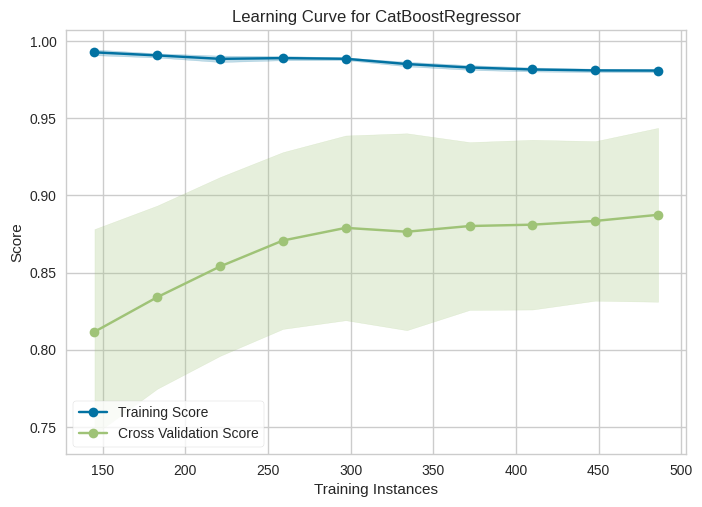

In [48]:
plot_model(final_model, plot = 'learning')

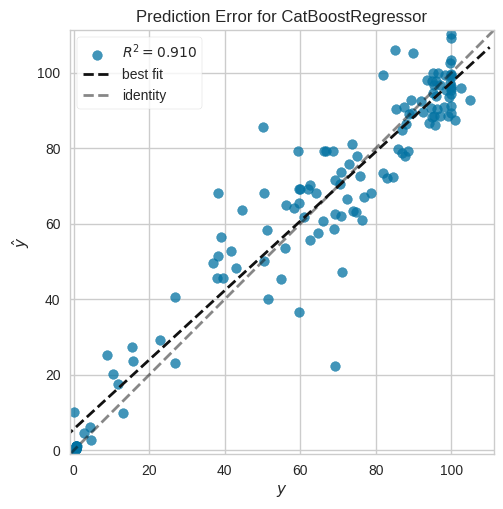

In [49]:
plot_model(final_model, plot = 'error')

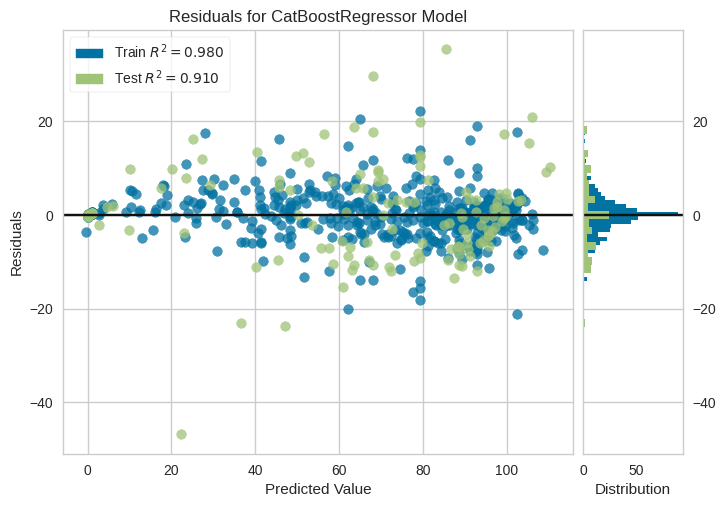

In [50]:
plot_model(final_model, plot = 'residuals')

### Feature importance plot

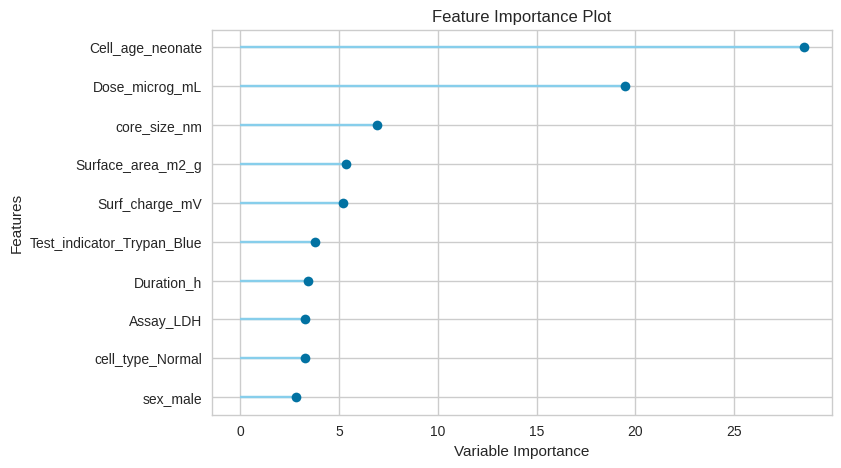

In [51]:
plot_model(final_model, plot = 'feature')

### Save the model to file

In [52]:
save_config('output/models/'+model_name+'_regression_config.cfg')

In [53]:
save_model(final_model, 'output/models/'+model_name+'_regression_model.mdl')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False,
                                       features_todrop=['nanomaterial_group',
                                                        'Coating', 'Cell_name'],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[], target='Viability',
                                       time_features=[])),
                 ('imputer',
                  Iterative_Imputer(add_indicator=False,
                                    classifier=LGBMClassifier(boosting_type...
                          target='Viability')),
                 ('cluster_all', 'passthrough'),
                 ('dummy', Dummify(target='Viability')),
                 ('fix_perfect', Remove_100(target='Viability')),
                 ('clean_names', Clean_Colum_Names()),
      

### Hyperparameter tuning

In [7]:
final_config = load_config('output/models/'+model_name+'_regression_config.cfg')

In [8]:
final_model = load_model('output/models/'+model_name+'_regression_model.mdl')

Transformation Pipeline and Model Successfully Loaded


In [9]:
final_model

Pipeline(steps=[('dtypes',
                 DataTypes_Auto_infer(display_types=False,
                                      features_todrop=['nanomaterial_group',
                                                       'Coating', 'Cell_name'],
                                      ml_usecase='regression',
                                      target='Viability')),
                ('imputer',
                 Iterative_Imputer(classifier=LGBMClassifier(random_state=123),
                                   max_iter=5, ordinal_columns=[],
                                   random_state=123,
                                   regressor=LGBMRegressor(random_state=123),
                                   target='Viabili...
                         target='Viability')),
                ('cluster_all', 'passthrough'),
                ('dummy', Dummify(target='Viability')),
                ('fix_perfect', Remove_100(target='Viability')),
                ('clean_names', Clean_Colum_Names()),
    

In [16]:
final_model.named_steps['trained_model'].learning_rate_

0.03714499995112419

In [17]:
final_model.named_steps['trained_model'].tree_count_ 

1000

In [18]:
params = {'depth'         : [4,5,6,7,8,9,10], #https://www.projectpro.io/recipes/find-optimal-parameters-for-catboost-using-gridsearchcv-for-classification
          'learning_rate' : [0.02,0.03,0.04,0.05],
          'iterations'    : [20,40,60,80,100,200,500,1000]
         }

In [19]:
tuned_model = tune_model(final_model.named_steps['trained_model'], custom_grid = params, search_algorithm='grid')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,7.3315,119.4177,10.9278,0.8967,0.2185,0.2170
1,6.1250,80.4128,8.9673,0.9278,0.2254,0.1591
2,5.8987,76.2669,8.7331,0.9329,0.3692,0.3913
3,7.8964,114.7513,10.7122,0.8760,0.1894,0.1834
4,8.7742,144.1093,12.0046,0.8752,0.2254,0.1968
5,5.7707,79.7282,8.9291,0.9370,0.2872,0.3105
6,8.1213,157.8587,12.5642,0.8772,0.3170,0.2987
7,10.4581,292.5363,17.1037,0.7468,0.3914,0.3264
8,5.9296,109.1102,10.4456,0.9172,0.2732,0.1797


In [20]:
predict_model(tuned_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,7.0480,99.3667,9.9683,0.9132,0.2875,0.6517


,core_size_nm,Surf_charge_mV,Surface_area_m2_g,Dose_microg_mL,Duration_h,NP_type_MWCNT,NP_type_Nanotubes,NP_type_SWCNT,Cell_species_Hamster,Cell_species_Human,Cell_species_Mouse,Cell_species_Rat,cell_Organ_Bladder,cell_Organ_Blood,cell_Organ_Lung,cell_Organ_Peritoneal Cavity,cell_Organ_Skin,cell_Organ_Teeth,cell_Organ_Umbilical,cell_Organ_Urinary bladder,Cell_morphology_Endothelial,Cell_morphology_Epidermal,Cell_morphology_Epithelial,Cell_morphology_Fibroblast,Cell_morphology_Macrophage,Cell_morphology_Monocyte/Macrophage,Cell_age_Adult,Cell_age_fetus,Cell_age_neonate,cell_type_Normal,sex_male,Assay_CCK_8,Assay_LDH,Assay_Live/Dead,Assay_MTS,Assay_MTT,Assay_NR,Assay_WST-1,Test_indicator_AlamarBlue,Test_indicator_TetrazoliumSalt,Test_indicator_Trypan_Blue,Test_indicator_toluylene red,Viability,Label
0,-0.209261,-0.835823,0.387538,0.705699,0.430198,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.690000,15.843598
1,-0.389381,1.551069,0.365748,-0.748791,1.412122,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,100.000000,94.019427
2,4.027051,-0.362407,-1.527255,0.414801,-0.551726,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,15.390000,28.574282
3,-0.108295,-0.198601,-1.540611,-0.166995,-0.551726,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,95.150002,100.669211
4,4.027051,-0.362407,-1.574459,-0.603342,-1.369997,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,85.760002,80.521171
5,-0.389381,1.523713,0.365748,0.414801,1.412122,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.700000,4.236918
6,-0.445599,-0.122465,0.555767,1.578393,-0.551726,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.400000,0.369125
7,-0.445599,-0.122465,0.555767,1.578393,-0.551726,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.560000,0.369125
8,-0.415616,1.758883,0.572187,-0.166995,-1.288170,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,55.840000,51.985442
9,4.027051,-0.362407,-1.547912,-0.603342,-0.551726,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,64.599998,60.592138


In [21]:
save_model(tuned_model, 'output/models/'+model_name+'_regression_model_tuned.mdl')

Transformation Pipeline and Model Successfully Saved


(Pipeline(steps=[('dtypes',
                  DataTypes_Auto_infer(display_types=False,
                                       features_todrop=['nanomaterial_group',
                                                        'Coating', 'Cell_name'],
                                       ml_usecase='regression',
                                       target='Viability')),
                 ('imputer',
                  Iterative_Imputer(classifier=LGBMClassifier(random_state=123),
                                    max_iter=5, ordinal_columns=[],
                                    random_state=123,
                                    regressor=LGBMRegressor(random_state=123),
                                    target='Viabili...
                          target='Viability')),
                 ('cluster_all', 'passthrough'),
                 ('dummy', Dummify(target='Viability')),
                 ('fix_perfect', Remove_100(target='Viability')),
                 ('clean_names', Clean_Col